# Initialiazation Packages

In [1]:
using LinearAlgebra
using PyPlot
using PyCall
using LaTeXStrings
using QuantumToolbox
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [32]:
using Pkg
Pkg.activate("..")

include("../src/Closed_2KPOs_QTB_functions.jl")
using .Coupled_KPOs_QTB_functions

  Activating project at `c:\Users\edson\Desktop\Research\Kerr_system\Coupled_KPOs`


### Entanglement Entropy
Measures the degree of entanglement between two subsystems, KPO1 and KPO2 in our case. Given a state from its density matrix ρ, we trace out KPO2 to obtain the reduced density matrix ρ_1=Tr_2 (ρ). The entanglement entropy is 


$$S_{1} = \sum_{n} \lambda_{n} \log{\lambda_{n}}$$


Where $\{ \lambda_{n} \}$ are the eigenvalues of $\rho_{1}$.   
Reference values:  
	- Fully chaotic state (max entangled): Page average entanglement entropy: 
$$S_{Page}=\sum_{k=d_B+1}^{d_A, d_B} k- \frac{d_A- 1}{(2d_B } ≈ \ln{d_{A}}⁡ - \frac{d_A}{2d_B}$$
For $d_A=d_B=100, S_Page=4.1052$.  
Product random state: $S_1=0$.  
Bell states of coherent states of the fixed points gives $S_1= \ln{2} \approx 0.6931875382925285$


## Uncoupled GS evolution

In [59]:
println("Loading defnitions")
N = 100
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ =  0., 1., 0., 5., 0., 1., 0., 5.,5.
Neff = 1
N_states=4000
Entroy_sum = zeros(N);
println("Done")

Loading defnitions
Done


In [ ]:
println("Diagonalization for time evolution")
println("Fock size N = $(100)^2")
t = time()
E_S_even, ψ_S_even, E_A_even, ψ_A_even, E_S_odd, ψ_S_odd, E_A_odd, ψ_A_odd = Coupled_kerr_equiv(p, N);
#Organizing 
all_energies = vcat(real.(E_S_even), real.(E_A_even), real.(E_S_odd), real.(E_A_odd));
all_states = hcat(ψ_S_even, ψ_A_even, ψ_S_odd, ψ_A_odd);
# Get sorting indices for energies (ascending order)
sorted_indices = sortperm(all_energies);
E = all_energies[sorted_indices];
ψ = all_states[:, sorted_indices];
N_states = 4000 #From Convergence test
#Fixing states below E = 0 (saddle point at (0,0,0,0))
E = E[1:N_states];
ψ = ψ[:,1:N_states];
println("time for Diagonalization: $(round((time()-t)/60, digits=3))")
println("Done")

Diagonalization for time evolution
Fock size N = 100^2


LoadError: UndefVarError: `Coupled_kerr_equiv` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.

In [20]:
println("Preparing output registers")
PR_unc = zeros(length(t_interval));
Entropy = zeros(length(t_interval));
n1, n2 = zeros(length(t_interval)), zeros(length(t_interval));
println("Done")

Preparing output registers
Done


In [23]:
println("Preparing the Initial Condition from Uncoupled GS")
#Uncoupled KPOs
E_unc, ψ_unc = H_un(p, N);
E_0s, ψ_0s = H_un(p, N, n_states = 2);
println("We choose GS | C_+ C_+ ⟩ as IC")
ψ_0, E_0 = ψ_0s[:,1], E_0s[1] 
println("Done")

println("Calculating the observable for the IC")
PR_unc[1] = 1.
n1_ = repeat(0:N-1, inner=N)
n1[1] = sum(abs2.(ψ_0) .* n1_)
n2_ = repeat(0:N-1, outer=N)
n2[1] = sum(abs2.(ψ_0) .* n2_)
Entropy[1] = 0.
println("Done")


Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done


In [56]:
println("Time interval definitions")
t_final,t_step = 0.1, 100
t_interval = range(0.0, t_final, length=t_step)
println("Evolution until t = $(t_final)/K in t_step = $(t_step)")
println("Done")

Time interval definitions
Evolution until t = 0.1/K in t_step = 100
Done


In [57]:
println("Begin evolution")
t = time()
for k in 2:length(t_interval)
    #Evolution trhough eigenbasis
    c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
    ψ_cj = ψ .* conj(c_j)'
    ψ_t = sum(ψ_cj, dims=2)
    
    ψ_t = vec(ψ_t)
    PR_unc[k] = ( 1 / sum(abs.(ψ_unc' * ψ_t).^4, dims=1))[1] 
    n1_ = repeat(0:N-1, inner=N)
    n1[k] = sum(abs2.(ψ_t) .* n1_)
    n2_ = repeat(0:N-1, outer=N)
    n2[k] = sum(abs2.(ψ_t) .* n2_)
    Entropy[k] = Coupled_KPOs_QTB_functions.Entanglement_entropy_fock(ψ_t, N)
end
println("Time elapsed for evolution: $(round((time() - t)/60, digits=3) )min")

Begin evolution
Time elapsed for evolution: 0.407min


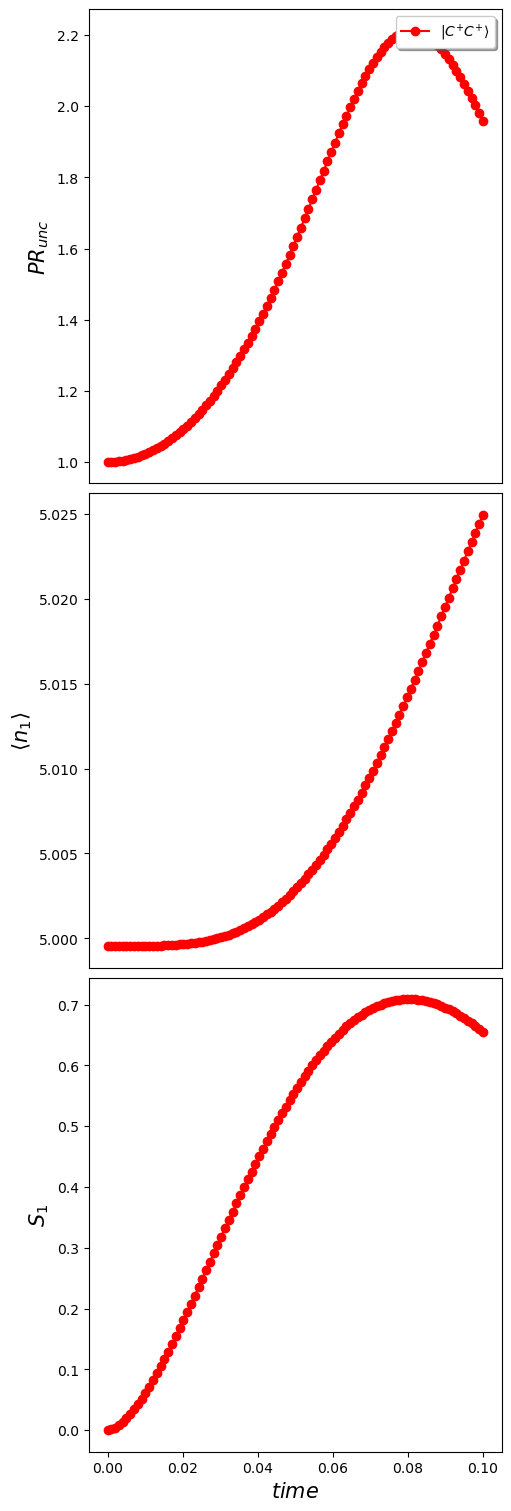

In [58]:
fig = figure(figsize=(5,15), layout= "constrained");
gs = fig.add_gridspec(3,1);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = Coupled_KPOs_QTB_functions.labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
labels_plots = [L"PR_{unc}", L"⟨n_{1}⟩", L"S_{1}"]
plots_list = [PR_unc, n1, Entropy] 

for i in 1:3
    ax = fig.add_subplot(element(i-1,0));
    plot(t_interval, plots_list[i], marker = markers_[1], color=colors_[1], label = labels_[1])
    
    if i == 1
        legend(fontsize=10, shadow=true, loc = "upper right");
    end
    ylabel(labels_plots[i], fontsize=15);
    if i ==3
        xlabel(L"time", fontsize=15);
    else
        xticks([])
    end
    
end
#fig.suptitle("Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ = $(p)", fontsize=15);
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/PR_unc_N_$(N)_p_$(p)_n_qudits_$(n_qudits).png")
